### Get the materials

In [326]:
# Requires the latest pip
# !pip3 install --user --upgrade pip

# Current stable release for CPU and GPU
# !pip3 install --user tensorflow
# !pip3 install --user keras

# conda install -c conda-forge keras tensorflow
# conda update -n base -c defaults conda
#!conda install -c conda-forge jupyterthemes
!pip3 install jupyterthemes

In [5]:
# unzip file with all images and labels
# filename = 'cifar-10-python.tar.gz'
# tar = tarfile.open(filename, 'r:gz')
# tar.extractall()
# tar.close()

In [3]:
projectpath = r'C:\Users\Sophie\sophie-robert\final-project'

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tarfile
import os
import pickle

In [6]:
# define a function to unpack the data into a dictionary
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding = 'bytes')
    return dict

In [118]:
# one hot encode the labels (could have just used keras.utils to_categorical)
def one_hot_encode(train_labels):
    encoded = np.zeros((n_imgs, len(np.unique(train_labels))))
    for idx,lbl in enumerate(train_labels,0):
        encoded[idx][lbl] = 1
    return encoded

In [132]:
# data comes in vectors so reshape then normalize
def reshape_data(batchdata):
    n_channels = 3
    n_imgs     = batchdata.shape[0]
    img_dim    = int(np.sqrt(batchdata.shape[1]/n_channels))
    train_data = batchdata.reshape((n_imgs, n_channels, img_dim, img_dim)).transpose(0, 2, 3, 1)
    train_data = (train_data / 255) - 0.5
    return train_data, img_dim

In [324]:
# unpack the data from the batches, do a bunch of stuff, then combine them
batchpath  = os.path.join(projectpath, 'cifar-10-batches-py')

for set in range(1,6):
    if set == 1:
        dirname      = os.path.join(batchpath, 'data_batch_' + str(set))
        batch        = unpickle(dirname)
        train_data   = reshape_data(batch[b'data'])        
        train_labels = one_hot_encode(batch[b'labels'])
    else:
        dirname       = os.path.join(batchpath, 'data_batch_' + str(set))
        batch         = unpickle(dirname)
        train_data2   = reshape_data(batch[b'data'])
        train_labels2 = one_hot_encode(batch[b'labels'])
        train_data    = np.concatenate((train_data, train_data2))
        train_labels  = np.concatenate((train_labels, train_labels2))

In [325]:
train_data.shape

(50000, 32, 32, 3)

In [289]:
# unpack the data from test batch, manipulate
batchpath   = os.path.join(projectpath, 'cifar-10-batches-py')
dirname     = os.path.join(batchpath, 'test_batch')
testbatch   = unpickle(dirname)
test_data   = reshape_data(testbatch[b'data'])        
test_labels = one_hot_encode(testbatch[b'labels'])

In [290]:
test_labels.shape

(10000, 10)

### Figure out what is in the batch

In [114]:
# what are the key types
list(batch.keys())

[b'batch_label', b'labels', b'data', b'filenames']

In [121]:
len(batch[b'labels'])

10000

In [103]:
# rows = images, columns = pixels in an image
batch[b'data'].shape 

(10000, 3072)

In [229]:
# back calculating the shape of the image
n_channels = 3
n_imgs = batch[b'data'].shape[0]
img_dim = int(np.sqrt(batch[b'data'].shape[1]/n_channels))

train_data = batch[b'data'].reshape((n_imgs, n_channels, img_dim, img_dim)).transpose(0, 2, 3, 1)

In [274]:
# normalize the images
train_data = (train_data / 255) - 0.5

### Build the network

In [317]:
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D, BatchNormalization, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 90s 2ms/step - loss: 1.5540 - accuracy: 0.4290 - val_loss: 2.7456 - val_accuracy: 0.1718
Epoch 2/100
40000/40000 [==============================] - 89s 2ms/step - loss: 1.1980 - accuracy: 0.5649 - val_loss: 1.1725 - val_accuracy: 0.5793
Epoch 3/100
40000/40000 [==============================] - 88s 2ms/step - loss: 1.0441 - accuracy: 0.6221 - val_loss: 1.0571 - val_accuracy: 0.6256
Epoch 4/100
40000/40000 [==============================] - 89s 2ms/step - loss: 0.9439 - accuracy: 0.6632 - val_loss: 0.9249 - val_accuracy: 0.6732
Epoch 5/100
40000/40000 [==============================] - 87s 2ms/step - loss: 0.8776 - accuracy: 0.6881 - val_loss: 0.8977 - val_accuracy: 0.6839
Epoch 6/100
40000/40000 [==============================] - 90s 2ms/step - loss: 0.8222 - accuracy: 0.7060 - val_loss: 0.9162 - val_accuracy: 0.6784
Epoch 7/100
40000/40000 [==============================] - 91s

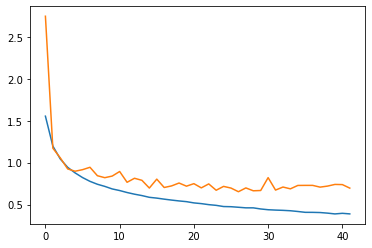

In [319]:
model = Sequential()
model.add(Conv2D(32, 
                 kernel_size = 3, 
                 activation  = 'relu', 
                 padding     = 'same', 
                 input_shape = (img_dim,
                                img_dim,
                                3)))
model.add(MaxPool2D(2))
model.add(Dropout(0.25))
model.add(Conv2D(32,
                 kernel_size = 5, 
                 activation  = 'relu',
                 padding     = 'same'))
model.add(MaxPool2D(2))
model.add(Dropout(0.25))
model.add(Conv2D(64,
                 kernel_size = 3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, 
                 activation='relu',
                 kernel_size = 3))
model.add(MaxPool2D(2))
model.add(Flatten())
model.add(Dense  (64,  activation='relu'))
model.add(Dense  (128))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense  (64,  activation='relu'))
model.add(Dense  (10,  activation='softmax'))

early_stopping_monitor = EarlyStopping(patience = 15,
                                       restore_best_weights = True)

model.compile(optimizer = 'adam', 
              loss      = 'categorical_crossentropy', 
              metrics   = ['accuracy'])

training = model.fit(train_data, 
                     train_labels, 
                     validation_split = 0.2, 
                     epochs = 100, 
                     batch_size = 125,
                     callbacks = [early_stopping_monitor])

model.save('model_saved9.h5')

plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.show()

In [331]:
training.history

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

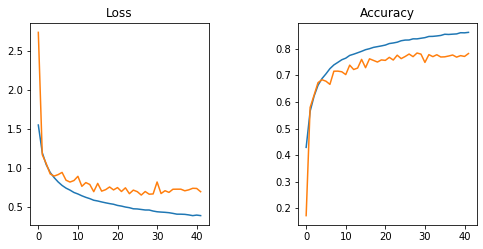

In [356]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].plot(training.history['loss'])
axs[0].plot(training.history['val_loss'])
axs[0].set_title('Loss')
axs[1].plot(training.history['accuracy'])
axs[1].plot(training.history['val_accuracy'])
axs[1].set_title('Accuracy')

fig.subplots_adjust(top = 0.8, bottom = 0.1, hspace = 0.5, wspace = 0.5)
plt.show()
fig.savefig('loss&accuracyModel9.png')

In [144]:
conv1 = model.layers[0]
weights1 = conv1.get_weights()
kernels1 = weights1[0]
kernels1.shape

(3, 3, 3, 16)

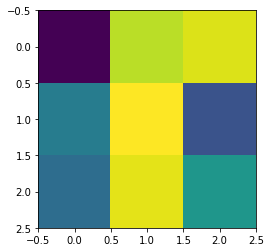

In [172]:
kernels1_1 = kernels1[:,:,:,0]
kernels1_1
kernels1_1avg = np.mean(kernels1_1, axis=0)

plt.imshow(kernels1_1avg);
plt.axis('off')

In [195]:
def convolution(kernel, image):
    img_dim     = image.shape[0]
    channels    = image.shape[2]
    kernel_size = kernel.shape[0]
    output_size = img_dim-(kernel_size-1)
    conv        = np.zeros((output_size,output_size))
    
    for ii in range(output_size):
        for jj in range(output_size):
            window = image[ii:ii+kernel_size, jj:jj+kernel_size]
            conv[ii,jj] = np.sum(window*kernel)
            
    return conv

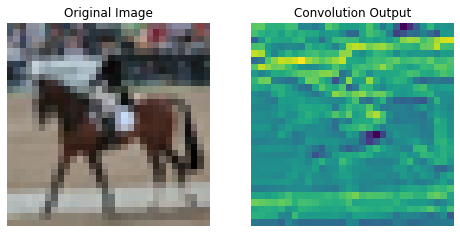

In [273]:
image = train_data[25,:,:,:]
conv = convolution(kernels1_1, image)

fig, axs = plt.subplots(1, 2, figsize=(8, 8))
axs[0].set_title('Original Image')
axs[0].imshow(image);
axs[0].axis('off')

axs[1].set_title('Convolution Output')
axs[1].imshow(conv);
axs[1].axis('off')
plt.show()

In [357]:
conv1    = my_model.layers[0]
weights1 = conv1.get_weights()
kernels1 = weights1[0] # shape of 32 kernels (3, 3, 3, 32)

kernels1_1 = kernels1[:,:,:,16]
kernels1_1avg = np.mean(kernels1_1, axis=0)

kernels1_2 = kernels1[:,:,:,17]
kernels1_2avg = np.mean(kernels1_2, axis=0)

fig, axs = plt.subplots(2, 3, figsize=(8, 8))
axs[0,0].imshow(kernels1_1[:,:,0], cmap=plt.cm.get_cmap('Reds', 6));
axs[0,0].axis('off');
axs[0,1].set_title('Kernel 1: edges?')
axs[0,1].imshow(kernels1_1[:,:,1], cmap=plt.cm.get_cmap('Greens', 6));
axs[0,1].axis('off');
axs[0,2].imshow(kernels1_1[:,:,2], cmap=plt.cm.get_cmap('Blues', 6));
axs[0,2].axis('off');

axs[1,0].imshow(kernels1_2[:,:,0], cmap=plt.cm.get_cmap('Reds', 6));
axs[1,0].axis('off');
axs[1,1].set_title('Kernel 2: horizontal?')
axs[1,1].imshow(kernels1_2[:,:,1], cmap=plt.cm.get_cmap('Greens', 6));
axs[1,1].axis('off');
axs[1,2].imshow(kernels1_2[:,:,2], cmap=plt.cm.get_cmap('Blues', 6));
axs[1,2].axis('off');

fig.subplots_adjust(top = 0.7, bottom = 0.1, hspace = 0.1, wspace = 0.1)

NameError: name 'my_model' is not defined

In [ ]:
image1 = train_data[1,:,:,:]
image2 = train_data[50,:,:,:]
conv1 = convolution(kernels1_1, image1)
conv2 = convolution(kernels1_1, image2)
conv3 = convolution(kernels1_2, image1)
conv4 = convolution(kernels1_2, image2)

fig, axs = plt.subplots(2, 4, figsize=(14, 14))
axs[0,0].set_title('Original Image')
axs[0,0].imshow(image1);
axs[0,0].axis('off');

axs[0,1].set_title('Convolution Output')
axs[0,1].imshow(conv1);
axs[0,1].axis('off');

axs[0,2].set_title('Original Image')
axs[0,2].imshow(image2);
axs[0,2].axis('off');

axs[0,3].set_title('Convolution Output')
axs[0,3].imshow(conv2);
axs[0,3].axis('off');

axs[1,0].set_title('Original Image')
axs[1,0].imshow(image1);
axs[1,0].axis('off');

axs[1,1].set_title('Convolution Output')
axs[1,1].imshow(conv3);
axs[1,1].axis('off');

axs[1,2].set_title('Original Image')
axs[1,2].imshow(image2);
axs[1,2].axis('off');

axs[1,3].set_title('Convolution Output')
axs[1,3].imshow(conv4);
axs[1,3].axis('off');

fig.subplots_adjust(top = 0.5, bottom = 0.1, hspace = 0.1, wspace = 0.1)
plt.show()
fig.savefig('conv_output.png')

In [295]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_63 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_62 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 16, 16, 32)        25632     
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_63 (Dropout)         (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 6, 6, 64)        

In [321]:
early_stopping_monitor = EarlyStopping(patience = 15)

score = model.evaluate(test_data, 
                       test_labels,
                       callbacks = [early_stopping_monitor], 
                       batch_size = 125)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 5s 535us/step
Test loss: 0.6816482432186604
Test accuracy: 0.7774999737739563
